## Random Sampling

Full Grid MAE (Original Scale): 7.3279
Full Grid RMSE (Original Scale): 10.3917
R² (Coefficient of Determination): 0.9963
SSIM (Structural Similarity Index): 0.9792
PSNR (Peak Signal-to-Noise Ratio): 41.6578 dB


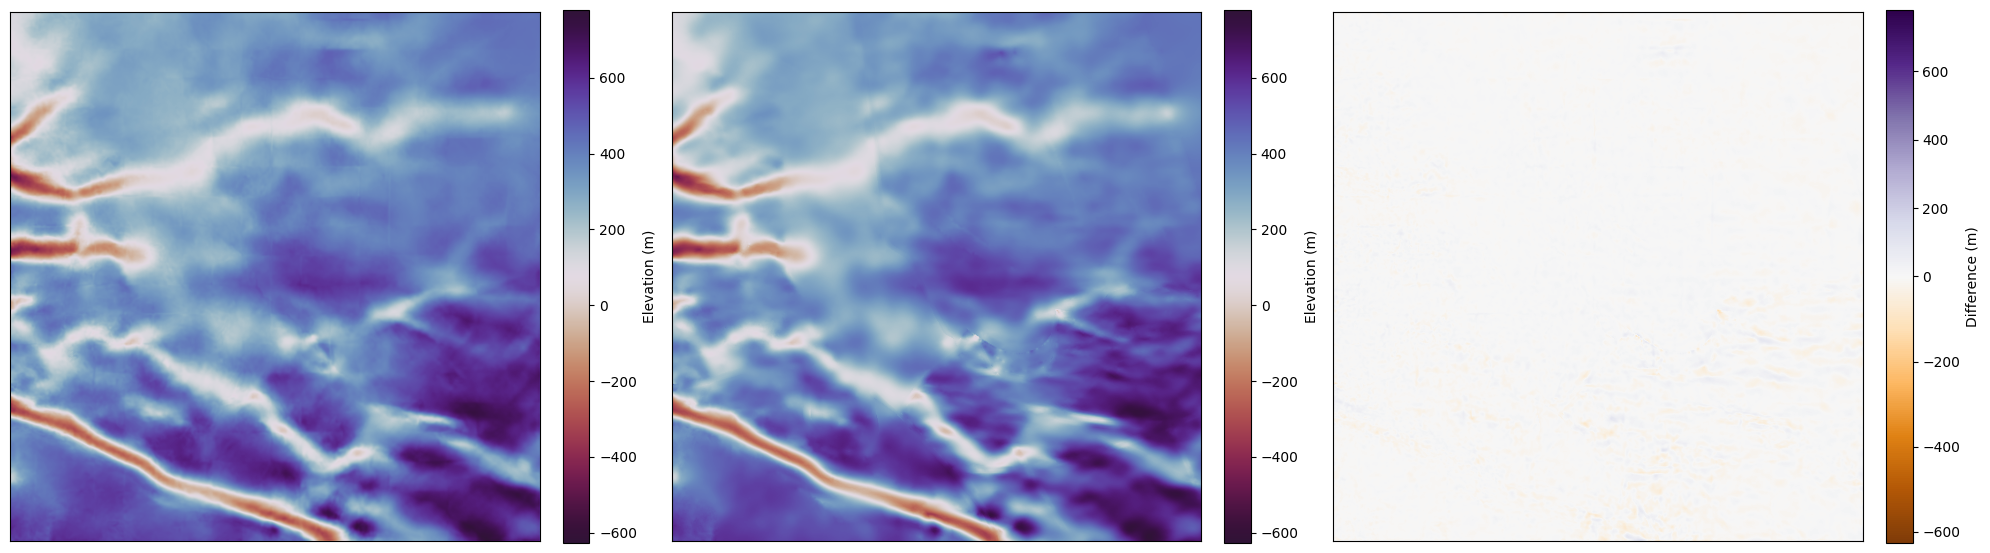

In [2]:
import torch
from grid_to_graph import grid_to_graph
from compute_radar_confidence import compute_radar_confidence
from trend_surface import trend_surface
from gradient_covariates import gradient_covariates
from model import BedTopoGCN

import warnings
from torch_geometric.data import Data
import numpy as np
import h5py
import pandas as pd
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
from metrics import compute_metrics

warnings.filterwarnings('ignore')
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

variables = ['surf_SMB', 'surf_dhdt', 'surf_elv', 'surf_vx', 'surf_vy', 'surf_x', 'surf_y']
data_dict = {}
with h5py.File('./data/hackathon.h5', 'r') as f:
    for var in variables:
        data_dict[var] = np.flipud(np.transpose(f[var][0:600, 600:1200])).copy()   # top-right: [0:600, 600:1200]

input_variables = ['surf_SMB', 'surf_dhdt', 'surf_elv', 'surf_vx', 'surf_vy']
inputs = np.stack([data_dict[var] for var in input_variables], axis=0)

gradient_features = gradient_covariates(inputs)
inputs = np.vstack([inputs, gradient_features])

trend_features = []
for i in range(inputs.shape[0]):
    trend = trend_surface(inputs[i])
    trend_features.append(trend)

trend_features = np.vstack(trend_features)
inputs = np.vstack([inputs, trend_features])

mean_inputs = inputs.mean(axis=(1, 2), keepdims=True)
std_inputs = inputs.std(axis=(1, 2), keepdims=True)
inputs = (inputs - mean_inputs) / std_inputs

with h5py.File('./data/bed_BedMachine.h5', 'r') as file:
    bedmachine_data = np.flipud(np.transpose(file['bed_BedMachine'][0:600, 600:1200])).copy() 
target_bed = bedmachine_data

mean_target = np.mean(target_bed)
std_target = np.std(target_bed)
target_bed = (target_bed - mean_target) / std_target

surf_x_min = np.min(np.abs(data_dict['surf_x']))
surf_y_min = np.min(np.abs(data_dict['surf_y']))
radar_mask = np.zeros(target_bed.shape, dtype=bool)

full_data_df = pd.read_csv('./data/data_full.csv')
for _, row in full_data_df.iterrows():
    x_idx = int(600 - np.round((np.abs(row['surf_x']) - surf_x_min) / 150) - 1)
    y_idx = int(np.round((np.abs(row['surf_y']) - surf_y_min) / 150))
    if 0 <= x_idx < 600 and 0 <= y_idx < 600:
        radar_mask[x_idx, y_idx] = True

radar_mask_tensor = torch.tensor(radar_mask, dtype=torch.bool)

radar_confidence = compute_radar_confidence(radar_mask)
radar_confidence_tensor = torch.tensor(radar_confidence.flatten(), dtype=torch.float32).to(device)

 
height, width = inputs[0].shape  
graph_inputs = inputs.reshape(inputs.shape[0], -1).T 
edge_index = grid_to_graph(height, width)  
graph_target = target_bed.flatten()

data = Data(x=torch.tensor(graph_inputs, dtype=torch.float32), 
            edge_index=edge_index, 
            y=torch.tensor(graph_target, dtype=torch.float32))

model = BedTopoGCN(in_channels=data.x.shape[1], hidden_channels=128, out_channels=1).to(device)
val_loss_radar = []
val_loss_bedmachine = []

model.load_state_dict(torch.load('./saved_models/best_bayesian_uncertainty_gcn_model_top_right.pth'))  
model.eval()
with torch.no_grad():
    
    graph_inputs = data.x.to(device)
    edge_index = data.edge_index.to(device)    
    full_predictions = model(graph_inputs, edge_index).squeeze()    
    full_predictions = full_predictions.view(target_bed.shape)  

    
    full_predictions_unnormalized = (full_predictions * std_target) + mean_target
    full_target_unnormalized = ((torch.tensor(target_bed, dtype=torch.float32) * std_target) + mean_target).to(device)    
    mae, rmse, r2, ssim_value, psnr_value = compute_metrics(full_predictions_unnormalized, full_target_unnormalized)

    print(f"Full Grid MAE (Original Scale): {mae:.4f}")
    print(f"Full Grid RMSE (Original Scale): {rmse:.4f}")
    print(f"R² (Coefficient of Determination): {r2:.4f}")
    print(f"SSIM (Structural Similarity Index): {ssim_value:.4f}")
    print(f"PSNR (Peak Signal-to-Noise Ratio): {psnr_value:.4f} dB")


difference = full_target_unnormalized - full_predictions_unnormalized  

min_value = -626.96027
max_value = 778.96765

plt.figure(figsize=(20, 6)) 
plt.subplot(1, 3, 1)
plt.imshow(full_predictions_unnormalized.cpu().numpy(), cmap='twilight_shifted_r', vmin=min_value, vmax=max_value,origin='lower')
plt.colorbar(label='Elevation (m)',fraction=0.046, pad=0.04)
plt.xticks([])
plt.yticks([])


plt.subplot(1, 3, 2)
plt.imshow(full_target_unnormalized.cpu().numpy(), cmap='twilight_shifted_r',vmin=min_value, vmax=max_value, origin='lower')
plt.colorbar(label='Elevation (m)',fraction=0.046, pad=0.04)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 3)
norm = TwoSlopeNorm(vmin=min_value, vcenter=0, vmax=max_value)
plt.imshow(difference.cpu().numpy(), cmap='PuOr', norm=norm, origin='lower')
plt.colorbar(label='Difference (m)',fraction=0.046, pad=0.04)
plt.xticks([])
plt.yticks([])

plt.tight_layout()

## Grid-Slicing

Full Grid MAE (Original Scale): 9.5872
Full Grid RMSE (Original Scale): 15.0839
R² (Coefficient of Determination): 0.9923
SSIM (Structural Similarity Index): 0.9653
PSNR (Peak Signal-to-Noise Ratio): 38.4214 dB


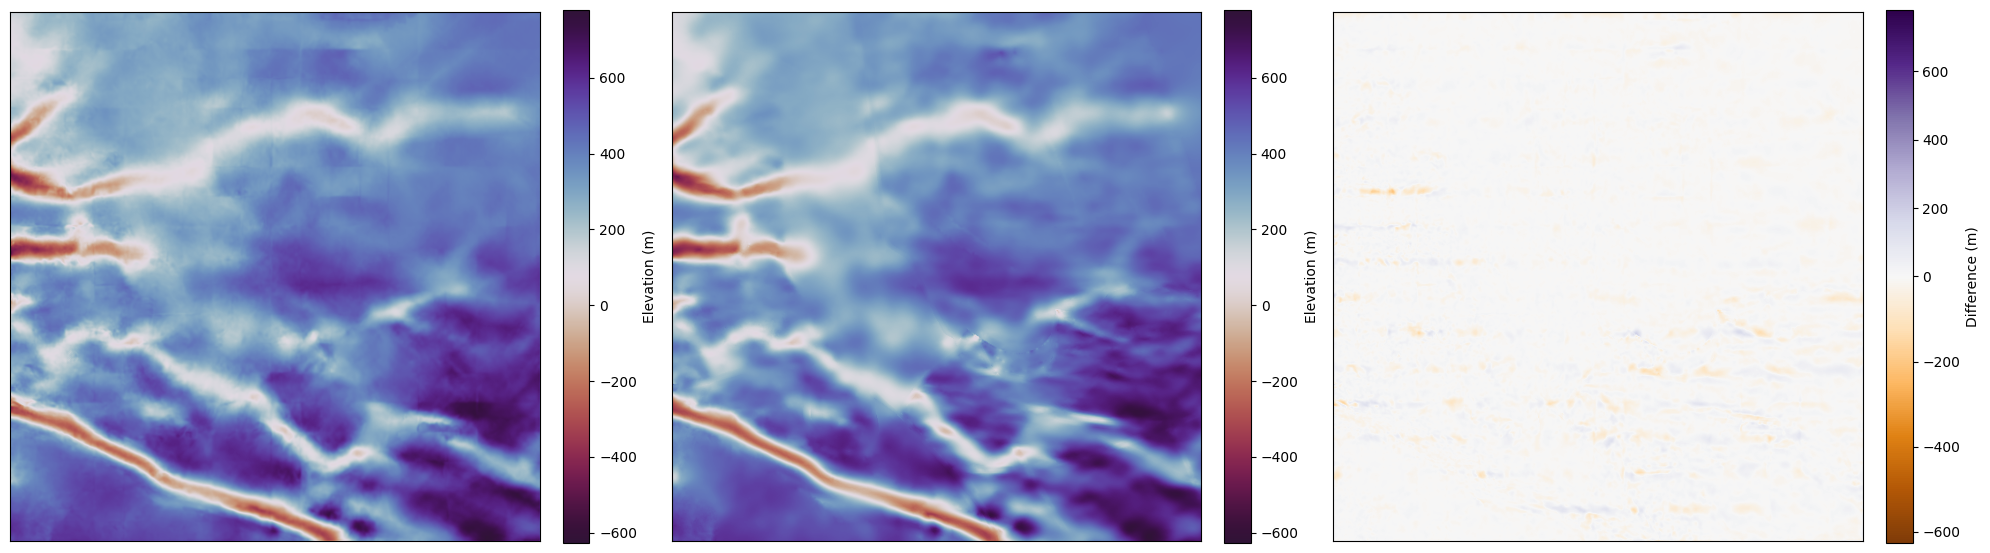

In [1]:
import torch
from grid_to_graph import grid_to_graph
from compute_radar_confidence import compute_radar_confidence
from trend_surface import trend_surface
from gradient_covariates import gradient_covariates
from model import BedTopoGCN

import warnings
from torch_geometric.data import Data
import numpy as np
import h5py
import pandas as pd
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
from metrics import compute_metrics

warnings.filterwarnings('ignore')
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

variables = ['surf_SMB', 'surf_dhdt', 'surf_elv', 'surf_vx', 'surf_vy', 'surf_x', 'surf_y']
data_dict = {}
with h5py.File('./data/hackathon.h5', 'r') as f:
    for var in variables:
        data_dict[var] = np.flipud(np.transpose(f[var][0:600, 600:1200])).copy()   # top-right: [0:600, 600:1200]

input_variables = ['surf_SMB', 'surf_dhdt', 'surf_elv', 'surf_vx', 'surf_vy']
inputs = np.stack([data_dict[var] for var in input_variables], axis=0)

gradient_features = gradient_covariates(inputs)
inputs = np.vstack([inputs, gradient_features])

trend_features = []
for i in range(inputs.shape[0]):
    trend = trend_surface(inputs[i])
    trend_features.append(trend)

trend_features = np.vstack(trend_features)
inputs = np.vstack([inputs, trend_features])

mean_inputs = inputs.mean(axis=(1, 2), keepdims=True)
std_inputs = inputs.std(axis=(1, 2), keepdims=True)
inputs = (inputs - mean_inputs) / std_inputs

with h5py.File('./data/bed_BedMachine.h5', 'r') as file:
    bedmachine_data = np.flipud(np.transpose(file['bed_BedMachine'][0:600, 600:1200])).copy() 
target_bed = bedmachine_data

mean_target = np.mean(target_bed)
std_target = np.std(target_bed)
target_bed = (target_bed - mean_target) / std_target

surf_x_min = np.min(np.abs(data_dict['surf_x']))
surf_y_min = np.min(np.abs(data_dict['surf_y']))
radar_mask = np.zeros(target_bed.shape, dtype=bool)

full_data_df = pd.read_csv('./data/data_full.csv')
for _, row in full_data_df.iterrows():
    x_idx = int(600 - np.round((np.abs(row['surf_x']) - surf_x_min) / 150) - 1)
    y_idx = int(np.round((np.abs(row['surf_y']) - surf_y_min) / 150))
    if 0 <= x_idx < 600 and 0 <= y_idx < 600:
        radar_mask[x_idx, y_idx] = True

radar_mask_tensor = torch.tensor(radar_mask, dtype=torch.bool)

radar_confidence = compute_radar_confidence(radar_mask)
radar_confidence_tensor = torch.tensor(radar_confidence.flatten(), dtype=torch.float32).to(device)

 
height, width = inputs[0].shape  
graph_inputs = inputs.reshape(inputs.shape[0], -1).T 
edge_index = grid_to_graph(height, width)  
graph_target = target_bed.flatten()

data = Data(x=torch.tensor(graph_inputs, dtype=torch.float32), 
            edge_index=edge_index, 
            y=torch.tensor(graph_target, dtype=torch.float32))

model = BedTopoGCN(in_channels=data.x.shape[1], hidden_channels=128, out_channels=1).to(device)
val_loss_radar = []
val_loss_bedmachine = []

model.load_state_dict(torch.load('./saved_models/best_bayesian_uncertainty_gcn_model_top_right_sliced.pth'))  
model.eval()
with torch.no_grad():
    
    graph_inputs = data.x.to(device)
    edge_index = data.edge_index.to(device)    
    full_predictions = model(graph_inputs, edge_index).squeeze()    
    full_predictions = full_predictions.view(target_bed.shape)  

    
    full_predictions_unnormalized = (full_predictions * std_target) + mean_target
    full_target_unnormalized = ((torch.tensor(target_bed, dtype=torch.float32) * std_target) + mean_target).to(device)    
    mae, rmse, r2, ssim_value, psnr_value = compute_metrics(full_predictions_unnormalized, full_target_unnormalized)

    print(f"Full Grid MAE (Original Scale): {mae:.4f}")
    print(f"Full Grid RMSE (Original Scale): {rmse:.4f}")
    print(f"R² (Coefficient of Determination): {r2:.4f}")
    print(f"SSIM (Structural Similarity Index): {ssim_value:.4f}")
    print(f"PSNR (Peak Signal-to-Noise Ratio): {psnr_value:.4f} dB")


difference = full_target_unnormalized - full_predictions_unnormalized  

min_value = -626.96027
max_value = 778.96765

plt.figure(figsize=(20, 6)) 
plt.subplot(1, 3, 1)
plt.imshow(full_predictions_unnormalized.cpu().numpy(), cmap='twilight_shifted_r', vmin=min_value, vmax=max_value,origin='lower')
plt.colorbar(label='Elevation (m)',fraction=0.046, pad=0.04)
plt.xticks([])
plt.yticks([])


plt.subplot(1, 3, 2)
plt.imshow(full_target_unnormalized.cpu().numpy(), cmap='twilight_shifted_r',vmin=min_value, vmax=max_value, origin='lower')
plt.colorbar(label='Elevation (m)',fraction=0.046, pad=0.04)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 3)
norm = TwoSlopeNorm(vmin=min_value, vcenter=0, vmax=max_value)
plt.imshow(difference.cpu().numpy(), cmap='PuOr', norm=norm, origin='lower')
plt.colorbar(label='Difference (m)',fraction=0.046, pad=0.04)
plt.xticks([])
plt.yticks([])

plt.tight_layout()